In [45]:
import pandas as pd
import plotly.express as px
import calendar
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/series_temporais_prophet/main/Dados/poluentes.csv')

In [3]:
df.head()

,Data,PM2.5,PM10,SO2,NO2,CO,O3,TEMP
0,2020-03-01,7.0,11.0,12.0,23.0,429.0,64.0,1.0
1,2020-03-02,31.0,42.0,37.0,67.0,825.0,30.0,1.0
2,2020-03-03,77.0,121.0,61.0,81.0,1621.0,19.0,6.0
3,2020-03-04,23.0,45.0,23.0,46.0,606.0,54.0,10.0
4,2020-03-05,149.0,184.0,94.0,133.0,2358.0,68.0,6.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    1460 non-null   object 
 1   PM2.5   1460 non-null   float64
 2   PM10    1460 non-null   float64
 3   SO2     1460 non-null   float64
 4   NO2     1460 non-null   float64
 5   CO      1460 non-null   float64
 6   O3      1460 non-null   float64
 7   TEMP    1460 non-null   float64
dtypes: float64(7), object(1)
memory usage: 91.4+ KB


In [5]:
df['Data'] = pd.to_datetime(df['Data'])

In [6]:
fig = px.line(df,x='Data', y='O3', title='Concentração de Ozônio ao longo do tempo')
fig.show()

In [7]:
df_2022 = df[df['Data'].dt.year == 2022]

df_2022_mensal = df_2022.groupby(df_2022['Data'].dt.month)['O3'].mean().reset_index()

df_2022_mensal['Mês'] = df_2022_mensal['Data'].apply(lambda x: calendar.month_abbr[x])

fig = px.bar(df_2022_mensal, x='Mês', y='O3', title='Média Mensal de Ozônio em 2022')

fig.update_layout(xaxis_title='Mês', yaxis_title='Concentração de Ozônio (µg/m³)')

### Nomearemos as colunas de forma que o Prophet consiga entendê-las.

In [8]:
df_prophet = pd.DataFrame()

df_prophet['ds'] = df['Data']
df_prophet['y'] = df['O3']

No Prophet, a coluna 'ds' representa as datas das observações e a coluna 'y' representa os valores da série temporal que queremos modelar e prever, neste caso, os valores em 'O3'.

In [9]:
df_prophet

,ds,y
0,2020-03-01,64.0
1,2020-03-02,30.0
2,2020-03-03,19.0
3,2020-03-04,54.0
4,2020-03-05,68.0
...,...,...
1455,2024-02-24,51.0
1456,2024-02-25,66.0
1457,2024-02-26,49.0
1458,2024-02-27,37.0


In [10]:
np.random.seed(4587)

modelo = Prophet()
modelo.fit(df_prophet)

futuro = modelo.make_future_dataframe(periods=365, freq='D') 
previsao = modelo.predict(futuro)

14:51:30 - cmdstanpy - INFO - Chain [1] start processing
14:51:30 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
fig = plot_plotly(modelo, previsao)
fig.show()

In [12]:
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-01,36.494445,-11.623355,49.668163,36.494445,36.494445,-17.561704,-17.561704,-17.561704,-2.094296,-2.094296,-2.094296,-15.467408,-15.467408,-15.467408,0.0,0.0,0.0,18.932741
1,2020-03-02,36.522801,-6.497420,53.983280,36.522801,36.522801,-13.457131,-13.457131,-13.457131,0.920265,0.920265,0.920265,-14.377396,-14.377396,-14.377396,0.0,0.0,0.0,23.065670
2,2020-03-03,36.551157,-7.388772,56.034138,36.551157,36.551157,-10.607233,-10.607233,-10.607233,2.599559,2.599559,2.599559,-13.206793,-13.206793,-13.206793,0.0,0.0,0.0,25.943924
3,2020-03-04,36.579513,-6.120709,55.330719,36.579513,36.579513,-11.789322,-11.789322,-11.789322,0.187277,0.187277,0.187277,-11.976599,-11.976599,-11.976599,0.0,0.0,0.0,24.790191
4,2020-03-05,36.607869,-3.579854,56.345704,36.607869,36.607869,-10.518326,-10.518326,-10.518326,0.190527,0.190527,0.190527,-10.708852,-10.708852,-10.708852,0.0,0.0,0.0,26.089543


- `ds`: datas das previsões.
- `yhat`: valor previsto pelo modelo para cada data.
- `yhat_lower`: limite inferior do intervalo de confiança da previsão.
- `yhat_upper`: limite superior do intervalo de confiança da previsão.

In [13]:
previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-03-01,18.932741,-11.623355,49.668163
1,2020-03-02,23.065670,-6.497420,53.983280
2,2020-03-03,25.943924,-7.388772,56.034138
3,2020-03-04,24.790191,-6.120709,55.330719
4,2020-03-05,26.089543,-3.579854,56.345704
...,...,...,...,...
1820,2025-02-23,40.157728,9.111859,68.718283
1821,2025-02-24,43.418420,13.544658,73.317839
1822,2025-02-25,45.501105,16.200041,76.332946
1823,2025-02-26,43.645661,12.858235,72.994965


O método plot_components_plotly(modelo, previsao) exibe, de forma interativa (usando Plotly), os componentes da previsão feita pelo Prophet. Ele mostra gráficos separados para:

- Tendência (trend): como a série evolui ao longo do tempo.
- Sazonalidade anual, semanal ou diária: padrões recorrentes ao longo do tempo.
- Feriados (se definidos): efeito de datas especiais.

Esses gráficos ajudam a entender como cada componente contribui para a previsão final do modelo Prophet. Você pode visualizar, por exemplo, se há uma tendência de alta/baixa, padrões sazonais ou outros efeitos no seu dado temporal.

In [14]:
plot_components_plotly(modelo, previsao)

In [15]:
df_prophet.shape

(1460, 2)

In [16]:
tamanho_treino = int(len(df_prophet) * 0.8)
tamanho_teste = int(len(df_prophet) - tamanho_treino)
print(f'Tamanho do treino: {tamanho_treino}, Tamanho do teste: {tamanho_teste}')

Tamanho do treino: 1168, Tamanho do teste: 292


In [17]:
df_treino = df_prophet.iloc[:tamanho_treino]
df_teste = df_prophet.iloc[tamanho_treino:]

In [18]:
np.random.seed(4587)

modelo = Prophet()
modelo.fit(df_treino)
futuro = modelo.make_future_dataframe(periods=292, freq='D')
previsao = modelo.predict(futuro)

14:51:31 - cmdstanpy - INFO - Chain [1] start processing
14:51:31 - cmdstanpy - INFO - Chain [1] done processing


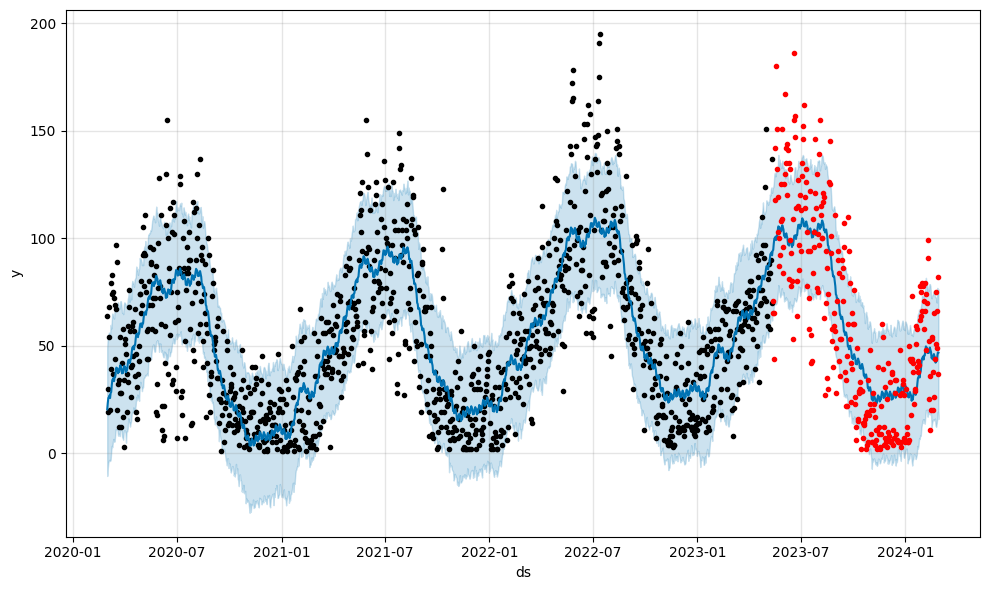

In [19]:
fig1 = modelo.plot(previsao)
plt.plot(df_teste['ds'], df_teste['y'], '.r' )
plt.show()

In [20]:
df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_teste, df_previsao, on='ds', how='left') 
df_comparacao.rename(columns={'y': 'Real', 'yhat': 'Previsto'}, inplace=True)
df_comparacao

,ds,Real,Previsto
0,2023-05-13,65.0,94.175323
1,2023-05-14,71.0,94.520946
2,2023-05-15,44.0,97.580729
3,2023-05-16,65.0,99.861569
4,2023-05-17,118.0,100.140206
...,...,...,...
287,2024-02-24,51.0,43.297996
288,2024-02-25,66.0,42.799012
289,2024-02-26,49.0,45.151820
290,2024-02-27,37.0,46.876336


In [21]:
mse = round(mean_squared_error(df_comparacao['Real'], df_comparacao['Previsto']), 2)
rmse = np.sqrt(mse).round(2)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MSE: 709.89
RMSE: 26.64


#### Remoção Outliers

In [22]:
#treinar o modelo sem periodo nenhum e utilizando o conjunto completo de dados
np.random.seed(4587)
modelo = Prophet()
modelo.fit(df_prophet)
futuro = modelo.make_future_dataframe(periods=0, freq='D')
previsao = modelo.predict(futuro)

14:51:32 - cmdstanpy - INFO - Chain [1] start processing
14:51:32 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# filtrando os outliers 
sem_outliers = df_prophet[(df_prophet['y'] > previsao['yhat_lower']) & (df_prophet['y'] < previsao['yhat_upper'])] 

In [24]:
sem_outliers.reset_index(drop=True, inplace=True)

In [25]:
tamanho_treino = int(len(sem_outliers) * 0.8)
tamanho_teste = int(len(sem_outliers) - tamanho_treino)
print(f'Tamanho do treino: {tamanho_treino}, Tamanho do teste: {tamanho_teste}')

Tamanho do treino: 961, Tamanho do teste: 241


In [26]:
df_treino_sem_outliers = pd.DataFrame()
df_treino_sem_outliers['ds'] = sem_outliers['ds'][:961]
df_treino_sem_outliers['y'] = sem_outliers['y'][:961]

In [27]:
df_teste_sem_outliers = pd.DataFrame()
df_teste_sem_outliers['ds'] = sem_outliers['ds'][961:]
df_teste_sem_outliers['y'] = sem_outliers['y'][961:]

In [28]:
np.random.seed(4587)
modelo = Prophet()
modelo.fit(df_treino_sem_outliers)
futuro = modelo.make_future_dataframe(periods=365, freq='D')
previsao = modelo.predict(futuro)

14:51:32 - cmdstanpy - INFO - Chain [1] start processing
14:51:32 - cmdstanpy - INFO - Chain [1] done processing


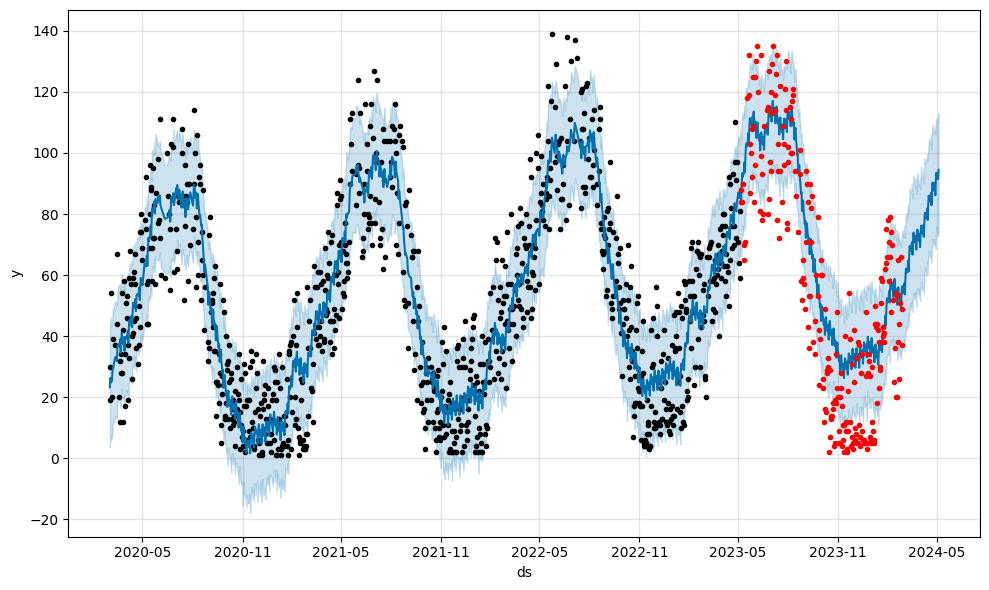

In [29]:
fig1 = modelo.plot(previsao)
plt.plot(df_teste_sem_outliers['ds'], df_teste_sem_outliers['y'], '.r')
plt.show()

In [30]:
df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste_sem_outliers, on='ds', how='inner')
df_comparacao.rename(columns={'y': 'Real', 'yhat': 'Previsto'}, inplace=True)
df_comparacao

,ds,Previsto,Real
0,2023-05-06,88.348526,88.0
1,2023-05-07,84.756880,84.0
2,2023-05-08,90.119345,84.0
3,2023-05-10,92.137551,90.0
4,2023-05-12,93.251778,70.0
...,...,...,...
236,2024-02-22,52.948734,44.0
237,2024-02-24,53.726696,51.0
238,2024-02-25,49.306067,66.0
239,2024-02-26,53.874343,49.0


In [31]:
rmse = np.sqrt(mean_squared_error(df_comparacao['Real'], df_comparacao['Previsto']))
print(f'RMSE: {round(rmse, 2)}')

RMSE: 19.72


14:51:33 - cmdstanpy - INFO - Chain [1] start processing
14:51:33 - cmdstanpy - INFO - Chain [1] done processing


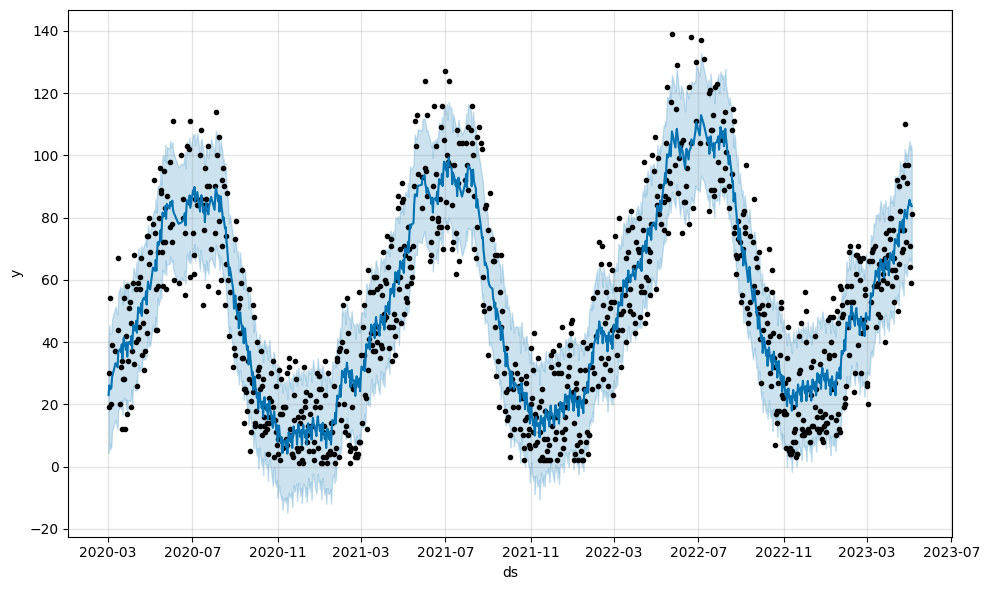

In [32]:
np.random.seed(4587)

modelo = Prophet(changepoint_prior_scale=0.5) #aumentar ou não a sensibilidade do modelo a mudanças bruscas
modelo.fit(df_treino_sem_outliers)
futuro = modelo.make_future_dataframe(periods=0, freq='D')
previsao = modelo.predict(futuro)
fig = modelo.plot(previsao)

In [33]:
fig = plot_components_plotly(modelo, previsao)
fig.show()

14:51:34 - cmdstanpy - INFO - Chain [1] start processing
14:51:34 - cmdstanpy - INFO - Chain [1] done processing


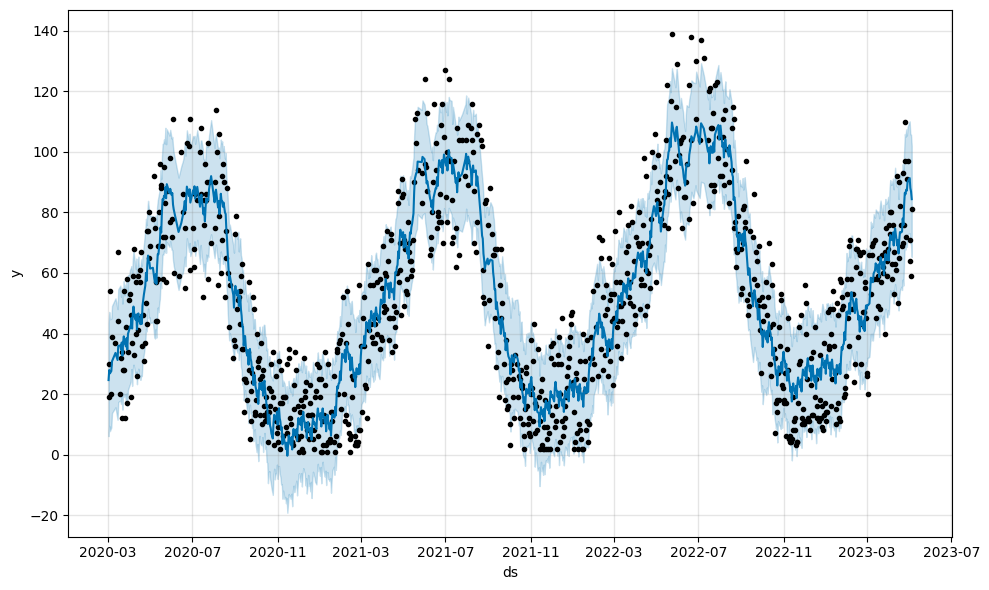

In [34]:
np.random.seed(4587)

modelo = Prophet(yearly_seasonality=20)
modelo.fit(df_treino_sem_outliers)
futuro = modelo.make_future_dataframe(periods=0, freq='D')
previsao = modelo.predict(futuro)
fig = modelo.plot(previsao)

In [35]:
np.random.seed(4587)
modelo_final = Prophet(yearly_seasonality=20, changepoint_prior_scale=0.5)
modelo_final.fit(df_treino_sem_outliers)
futuro = modelo_final.make_future_dataframe(periods=365, freq='D')
previsao = modelo_final.predict(futuro)

14:51:34 - cmdstanpy - INFO - Chain [1] start processing
14:51:34 - cmdstanpy - INFO - Chain [1] done processing


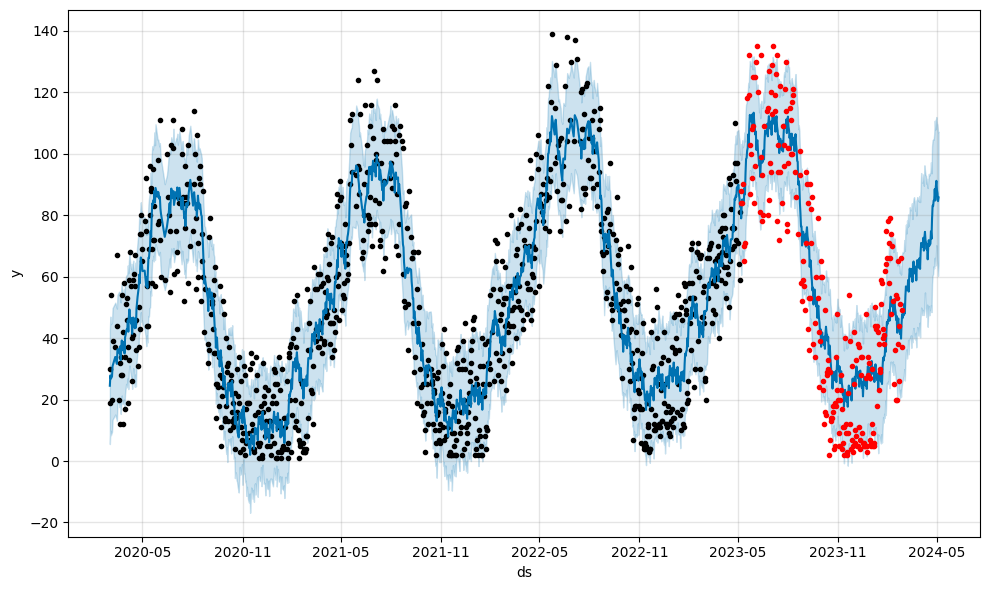

In [36]:
fig1 = modelo.plot(previsao)
plt.plot(df_teste_sem_outliers['ds'], df_teste_sem_outliers['y'], '.r')

In [37]:
df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste_sem_outliers, on='ds', how='inner')
df_comparacao.rename(columns={'y': 'Real', 'yhat': 'Previsto'}, inplace=True)
df_comparacao

,ds,Previsto,Real
0,2023-05-06,84.129913,88.0
1,2023-05-07,78.970095,84.0
2,2023-05-08,83.015558,84.0
3,2023-05-10,83.436698,90.0
4,2023-05-12,84.533961,70.0
...,...,...,...
236,2024-02-22,42.957777,44.0
237,2024-02-24,43.859358,51.0
238,2024-02-25,39.839904,66.0
239,2024-02-26,44.898211,49.0


In [38]:
rmse = np.sqrt(mean_squared_error(df_comparacao['Real'], df_comparacao['Previsto']))
print(f'RMSE: {round(rmse, 2)}')

RMSE: 17.53


## Validação Cruzada

In [40]:
df_cv = cross_validation(modelo_final, initial='365.25 days', period='45 days', horizon='90 days')

  0%|          | 0/16 [00:00<?, ?it/s]15:02:24 - cmdstanpy - INFO - Chain [1] start processing
15:02:24 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:04,  3.60it/s]15:02:24 - cmdstanpy - INFO - Chain [1] start processing
15:02:24 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:03,  3.83it/s]15:02:24 - cmdstanpy - INFO - Chain [1] start processing
15:02:24 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:03,  3.87it/s]15:02:25 - cmdstanpy - INFO - Chain [1] start processing
15:02:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:01<00:03,  3.92it/s]15:02:25 - cmdstanpy - INFO - Chain [1] start processing
15:02:25 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:01<00:02,  3.95it/s]15:02:25 - cmdstanpy - INFO - Chain [1] start processing
15:02:25 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 6/16 [00:01<00:02,  3.80it/s]15:02:25

In [41]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-04-01,46.999872,30.455574,64.816995,55.0,2021-03-31
1,2021-04-02,45.482528,28.179321,62.805181,69.0,2021-03-31
2,2021-04-03,47.505417,30.932370,64.742432,49.0,2021-03-31
3,2021-04-04,45.073780,27.875091,61.445413,47.0,2021-03-31
4,2021-04-05,53.756059,36.997577,70.042960,60.0,2021-03-31


In [42]:
df_cv['cutoff'].unique()

<DatetimeArray>
['2021-03-31 00:00:00', '2021-05-15 00:00:00', '2021-06-29 00:00:00',
 '2021-08-13 00:00:00', '2021-09-27 00:00:00', '2021-11-11 00:00:00',
 '2021-12-26 00:00:00', '2022-02-09 00:00:00', '2022-03-26 00:00:00',
 '2022-05-10 00:00:00', '2022-06-24 00:00:00', '2022-08-08 00:00:00',
 '2022-09-22 00:00:00', '2022-11-06 00:00:00', '2022-12-21 00:00:00',
 '2023-02-04 00:00:00']
Length: 16, dtype: datetime64[ns]

In [43]:
df_p = performance_metrics(df_cv)

In [44]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,354.989823,18.841174,15.569337,1.144625,0.284758,0.468200,0.583652
1,11 days,350.147664,18.712233,15.495823,1.171234,0.281852,0.480209,0.559664
2,12 days,339.200718,18.417403,15.535979,1.239296,0.284758,0.494657,0.559664
3,13 days,355.037572,18.842441,15.891938,1.259025,0.299263,0.505261,0.567227
4,14 days,367.461736,19.169291,16.425528,1.248296,0.332975,0.518273,0.558824
...,...,...,...,...,...,...,...,...
76,86 days,310.531275,17.621898,15.309031,0.532339,0.257495,0.364814,0.574484
77,87 days,281.755424,16.785572,14.502515,0.419690,0.249425,0.326929,0.613445
78,88 days,296.214545,17.210884,15.066118,0.465191,0.253984,0.344462,0.594958
79,89 days,310.712735,17.627046,15.279909,0.502125,0.267785,0.359613,0.583064


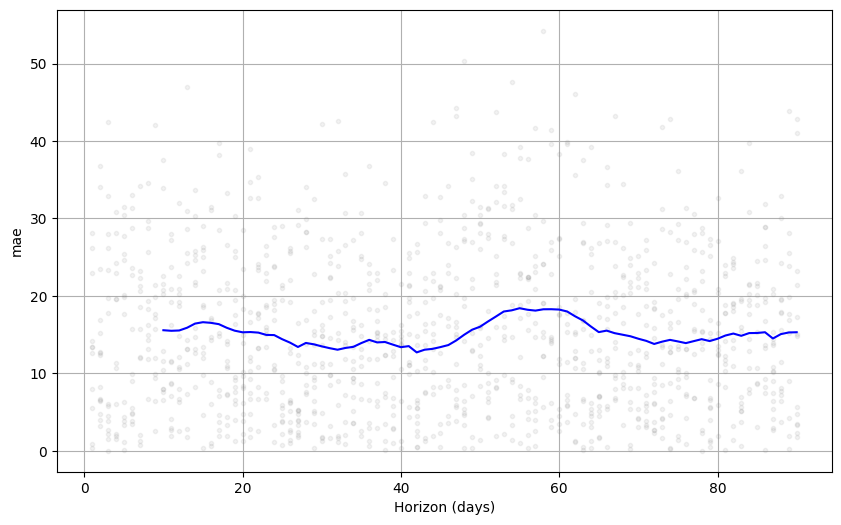

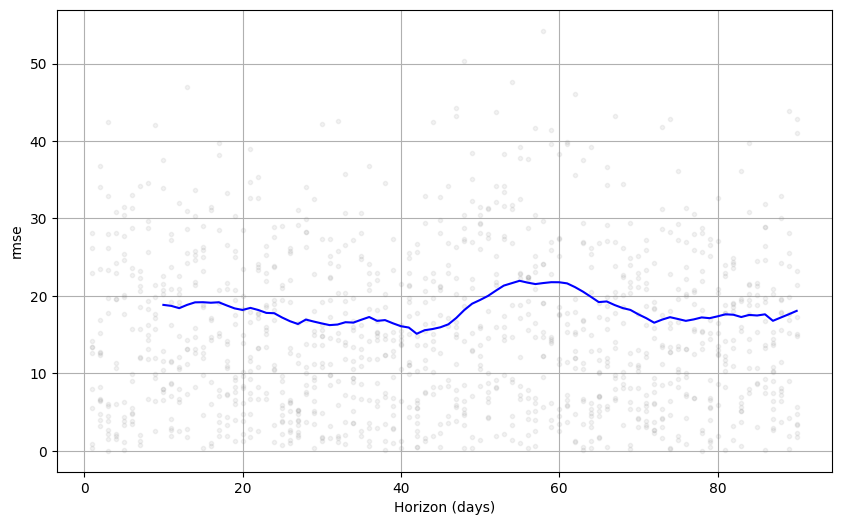

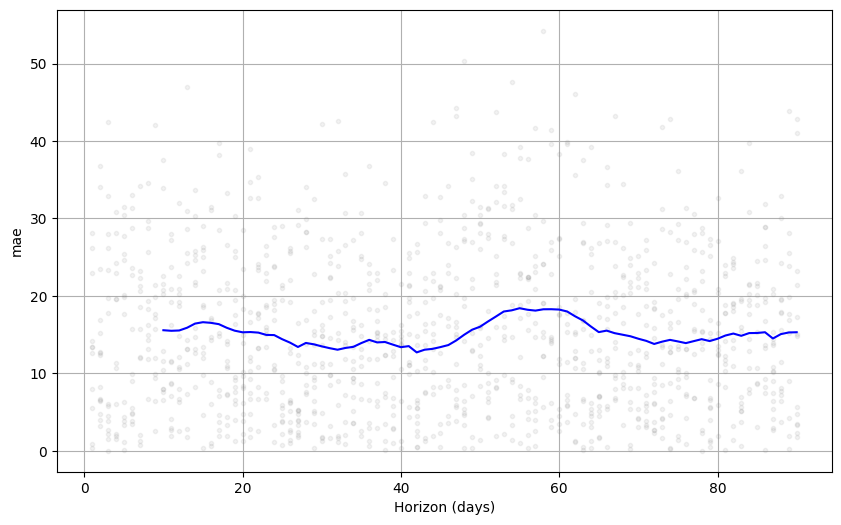

In [47]:
plot_cross_validation_metric(df_cv, metric='rmse')
plot_cross_validation_metric(df_cv, metric='mae')